In [1]:
# Change the path through the data 
falcon_path = "/home/chaputmarine/Desktop/falcon_ripple_latency"

In [2]:
import yaml
import numpy as np
import glob
import os
import ast

# Utilities

In [3]:
def read_yaml_header( stream ):
    """Reads YAML header from stream.
    
    Parameters
    ----------
    stream : open file
    
    Returns
    -------
    header : YAML node
    headersize
    
    """
    
    s = stream.read(4)
    if (s.decode()!="---\n"):
        raise Exception("Invalid yaml header")
    
    header = ""
    s=b""
    while ( s.decode()!="...\n" ):
        header += s.decode()
        s = stream.readline()
    return yaml.safe_load(header), stream.tell()


def data_description_to_dtype( desc ):
    """Converts data description string to numpy stype.
    
    Parameters
    ----------
    desc : string
    
    Returns
    -------
    dtype
    
    """
    
    dt = []
    
    for field in desc:
        
        parts = field.split(" ")
        
        if len(parts)!=3:
            raise Exception("Invalid field description")
        
        if parts[1]=='string': parts[1]='str'
        
        parts[2] = parts[2].replace('[','(').replace(']',')')
        dt.append( (parts[0], (getattr(np,parts[1]),ast.literal_eval(parts[2]))) )
    return np.dtype( dt )


def load_file( filename ):
    """Loads data from serialized Falcon data file.
    
    Parameters
    ----------
    filename : string
    
    Returns
    -------
    data : YAML node or numpy array;
    
    header : YAML node
    
    """
    
    with open( filename, 'rb' ) as fid:
        
        #load header
        header, headersize = read_yaml_header( fid )
        
        if header["encoding"]=="BINARY":
            dt = data_description_to_dtype( header["data"] )
            data = np.memmap( filename, dtype=dt, mode='r', offset=headersize )
        elif header["encoding"]=="YAML":
            data = yaml.safe_load( fid )
        else:
            raise Exception("Unknown encoding")
        
    return data, header

def read_yaml_data(data):
    hdw = []
    src = []
    for packet in data:
        hdw.append(packet["data"]["hardware_ts"])
        src.append(packet["data"]["source_ts"])
    return np.array(hdw), np.array(src)


# Load data

### Falcon Alpha data

In [4]:
# Read Source 
source_alpha, header= load_file(glob.glob(os.path.join(falcon_path, "falcon_alpha/datasink-source/*"))[0])
# Read stats data
stats_alpha, header= load_file(glob.glob(os.path.join(falcon_path, "falcon_alpha/datasink-ripplestats/*"))[0])
# Read event data
event, header= load_file(glob.glob(os.path.join(falcon_path, "falcon_alpha/datasink-ev/*"))[0])
detect_hdw_alpha, detect_src_alpha = read_yaml_data(event)  

/home/chaputmarine/miniconda3/envs/fkdev/lib/python3.7/site-packages/ipykernel_launcher.py:53: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.


### Falcon Beta data

In [5]:
source_beta, header= load_file(glob.glob(os.path.join(falcon_path, "falcon_beta/datasink-source/*"))[0])
stats_beta, header= load_file(glob.glob(os.path.join(falcon_path, "falcon_beta/datasink-ripplestats/*"))[0])
# Read event data
event, header= load_file(glob.glob(os.path.join(falcon_path, "falcon_beta/datasink-ev/*"))[0])
detect_hdw_beta, detect_src_beta = read_yaml_data(event) 
# Output delayed node
event, header= load_file(glob.glob(os.path.join(falcon_path, "falcon_beta/datasink-stimulation/*"))[0])
stim_hdw_beta, stim_src_beta = read_yaml_data(event)


/home/chaputmarine/miniconda3/envs/fkdev/lib/python3.7/site-packages/ipykernel_launcher.py:53: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.


## Synchonize source / Hdw timestamp

In [6]:
from matplotlib import pyplot as plt

def synchro_plot(ax, source, hdw):
    start_time = 0
    end_time = 30000
    #ax.set_ylim(0,0.4)
    ax.scatter(np.arange(len(source)),source-source[0]+hdw[0], color='blue') 
    ax.scatter(np.arange(len(source)),hdw, color='red') 
    #ax.set_xlim([start_time, end_time ])
    ax.set_xlabel("time [ms]")
    ax.grid(which='major', linestyle='-')
    ax.set_ylabel("timestamps [ms]")


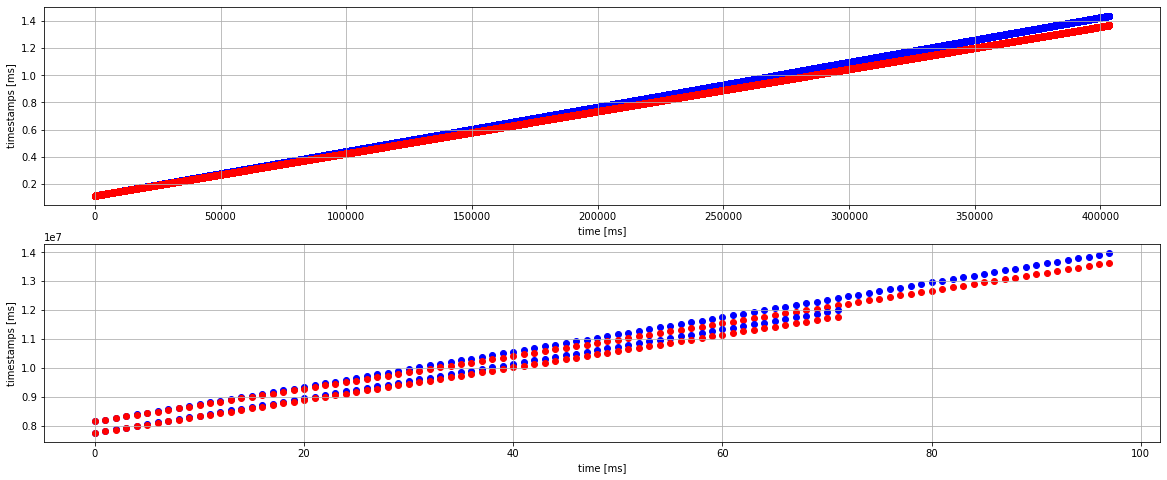

In [7]:
fig, ax = plt.subplots(2, figsize = (20,8))
synchro_plot(ax[0], source_alpha['source_ts']/(4*1e7), source_alpha['timestamps']/1e7)
synchro_plot(ax[1], detect_src_alpha/(4), detect_hdw_alpha)
synchro_plot(ax[1], detect_src_beta/(4), detect_hdw_beta)

In [8]:
#detect_src_alpha = detect_src_alpha/4
#detect_src_alpha = detect_src_alpha-detect_src_alpha[0] + source_alpha['timestamps'][0] 

#detect_src_beta = detect_src_beta/4
#detect_src_beta =detect_src_beta-detect_src_beta[0]  + source_beta['timestamps'][0] 

#stim_src_beta = stim_src_beta/4
#stim_src_beta = stim_src_beta-stim_src_beta[0] + source_beta['timestamps'][0] 

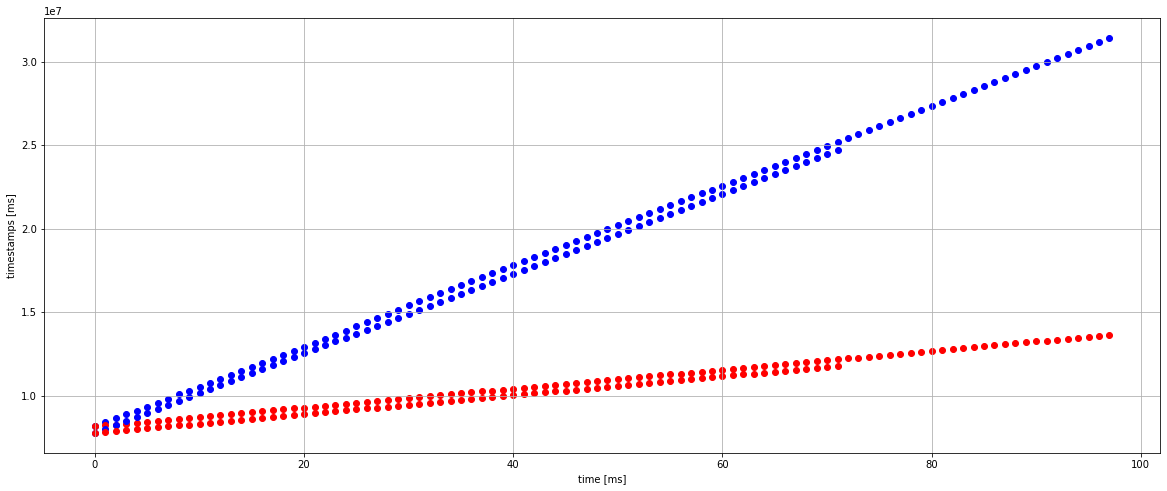

In [9]:
fig, ax = plt.subplots(1, figsize = (20,8))
synchro_plot(ax, detect_src_alpha, detect_hdw_alpha)
synchro_plot(ax, detect_src_beta, detect_hdw_beta)

## Filtering Step

In [10]:
from matplotlib import pyplot as plt

def filtering_plot(ax, source, stats, detection):
    start_time = (source['timestamps'][322689])/1e3
    end_time = (source['timestamps'][344660])/1e3

    for packet in range(stats.size):
        ax.plot(stats['timestamps'][packet]/1e3-start_time, stats['signal'][packet,0,:], color="red") 
        
    for xc in detection:
        ax.axvline(x=xc/1e3-start_time, color="green")
        
    ax.plot((source['timestamps'][:])/1e3-start_time, source['signal'][:,0], color='blue') 
    ax.set_xticks(np.arange(0, end_time-start_time, step=50))
    ax.set_xlim([0, end_time-start_time ])
    ax.set_xlabel("time [ms]")
    ax.grid(which='major', linestyle='-')
    ax.set_ylabel("voltage [uV]")


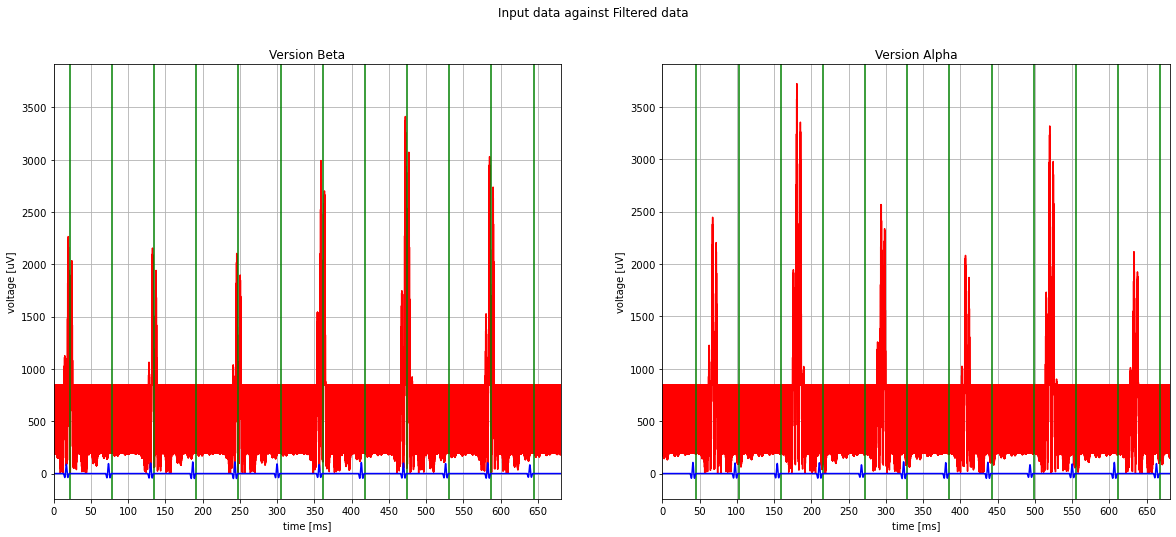

In [11]:
fig, ax = plt.subplots(1, 2, figsize = (20,8))
filtering_plot(ax[0], source_beta, stats_beta, detect_hdw_beta )
ax[0].set_title("Version Beta")
filtering_plot(ax[1], source_alpha, stats_alpha, detect_hdw_alpha)
ax[1].set_title("Version Alpha")

plt.suptitle("Input data against Filtered data")
plt.show()

## Compare Hardware detection time against a ripple

In [12]:
def hdw_detection_plot(ax, source, detection, src_detection, stimulation=None, src_stimulation=None):
    start_time = (source['timestamps'][322489])/1e3
    end_time = (source['timestamps'][324760])/1e3
    ax.set_xlim([0, end_time-start_time])
    ax.set_xticks(np.arange(0, end_time-start_time, step=2))
    ax.plot(source['timestamps']/1e3-start_time, source['signal'][:,0], color='blue') 

    for xc in detection:
        ax.axvline(x=xc/1e3-start_time, color="red")
    
    for xc in src_detection:
        ax.axvline(x=xc/1e3-start_time, color="k")
        
    if stimulation is not None:
        for xc in stimulation:
            ax.axvline(x=xc/1e3-start_time, color="green")
            
        for xc in src_stimulation:
            ax.axvline(x=xc/1e3-start_time, color="y")
            
    ax.set_xlabel("time [ms]")
    ax.grid(which='major', linestyle='-')
    ax.set_ylabel("voltage [uV]")

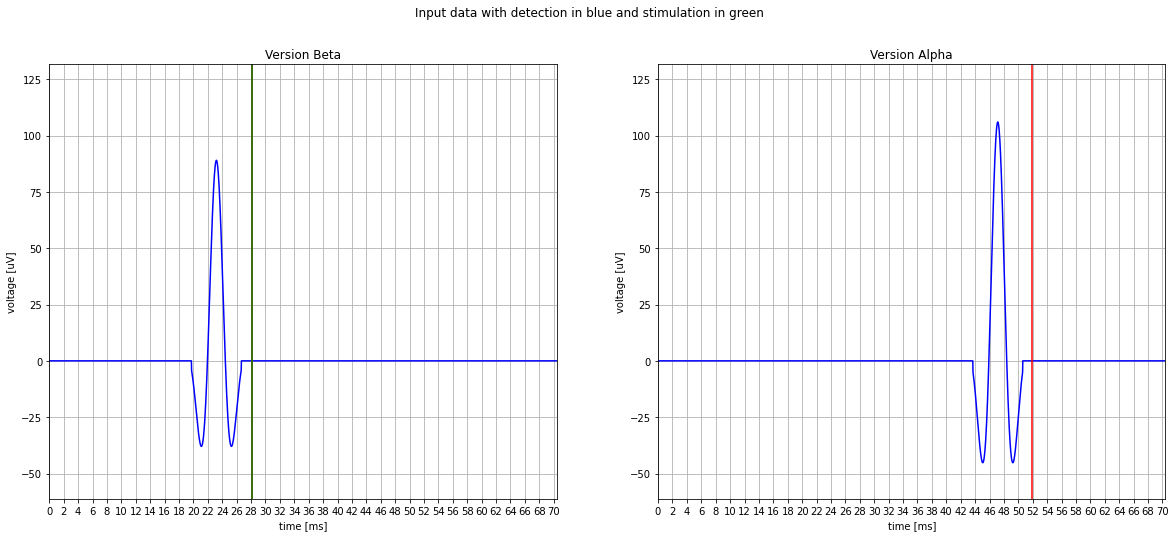

In [13]:
fig, ax = plt.subplots(1, 2, figsize = (20,8))
hdw_detection_plot(ax[0], source_beta, detect_hdw_beta, detect_src_beta, 
                   stimulation=stim_hdw_beta, src_stimulation=stim_src_beta)
ax[0].set_title("Version Beta")
hdw_detection_plot(ax[1], source_alpha, detect_hdw_alpha, detect_src_alpha)
ax[1].set_title("Version Alpha")

plt.suptitle("Input data with detection in blue and stimulation in green")
plt.show()

## Compare Source detection time against a ripple

In [14]:
def src_detection_plot(ax, source, detection, stimulation=None):

    start_time = source['source_ts'][322689]/1e3
    end_time = source['source_ts'][324460]/1e3
    ax.set_xlim([0, end_time-start_time])
    ax.plot((source['source_ts'][:]/1e3 - start_time), source['signal'][:,0], color='blue') 
    ax.set_xticks(np.arange(0, end_time-start_time, step=10))
    for xc in detection:
        ax.axvline(x=xc/1e3-start_time, color="red")
    
    if stimulation is not None:
        for xc in stimulation:
            ax.axvline(x=xc/1e3-start_time, color="green")

    ax.set_xlabel("time [ms]")
    ax.grid(which='major', linestyle='-')
    ax.set_ylabel("voltage [uV]")

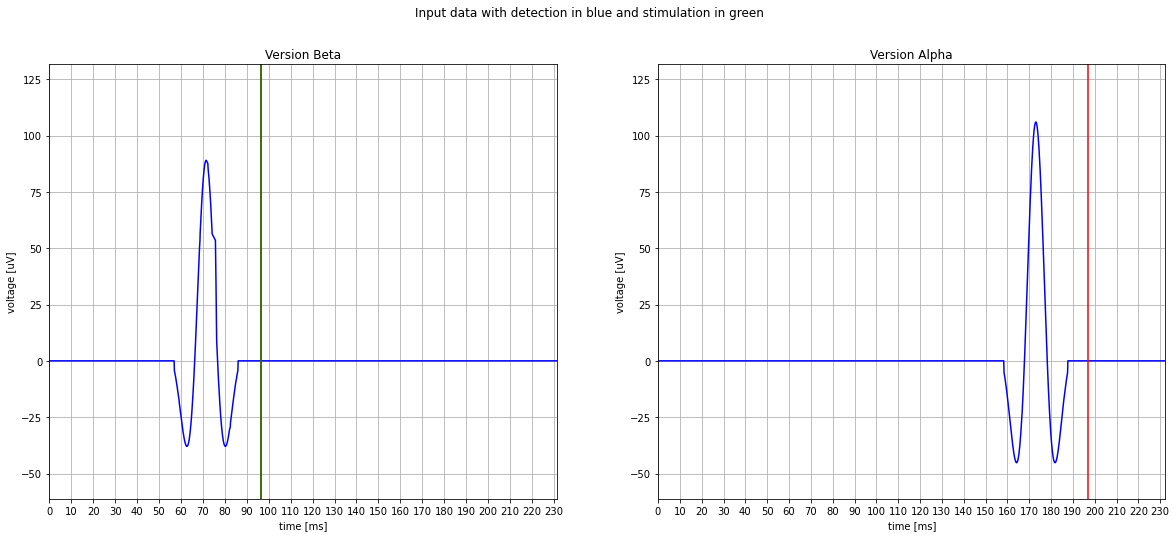

In [15]:
fig, ax = plt.subplots(1, 2, figsize = (20,8))
src_detection_plot(ax[0], source_beta, detect_src_beta, stimulation=stim_src_beta)
ax[0].set_title("Version Beta")
src_detection_plot(ax[1], source_alpha, detect_src_alpha)
ax[1].set_title("Version Alpha")

plt.suptitle("Input data with detection in blue and stimulation in green")
plt.show()